**Predicting used car price**

In [2]:
#Importing libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr

sns.set(style="whitegrid")

RQ1: What are the most influential factors in determining the price of a used car?

I calculate and visualize the correlation matrix between price and other key numerical features.

I use a heatmap here because it gives a quick, intuitive snapshot of linear relationships between variables. I'm particularly interested in how strongly each feature correlates with price.

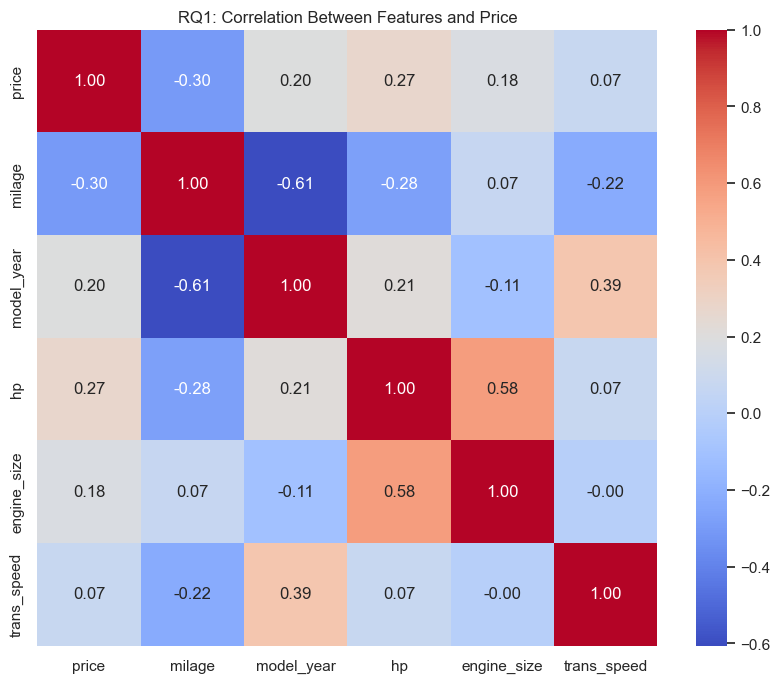

In [3]:
df = pd.read_csv("../src/data/used_cars_cleaned.csv")

# -------------------------------
# RQ1: Most Influential Features
# -------------------------------
numeric_features = ["price", "milage", "model_year", "hp", "engine_size", "trans_speed"]
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("RQ1: Correlation Between Features and Price")
plt.show()


Mileage shows the strongest negative correlation with price (-0.30), meaning that cars with higher mileage generally cost less.

Horsepower and model year both have moderate positive correlations (+0.27 and +0.20, respectively), suggesting newer, more powerful cars tend to be more expensive.

Engine size has a weaker positive relationship, while transmission speed appears to have minimal effect on price.

This confirms that mileage, horsepower, and model year are likely to be the most impactful numeric features when predicting car prices, which helps guide my feature selection for modeling.

Next I analyze how specific attributes — namely accident history and fuel type — relate to the price of a used car. These are categorical variables that could significantly influence a buyer’s decision and thus affect resale value.

I plot this boxplot to compare the distribution of car prices between vehicles with and without reported accidents. Using 0 and 1 as binary indicators keeps the categories clean and interpretable.

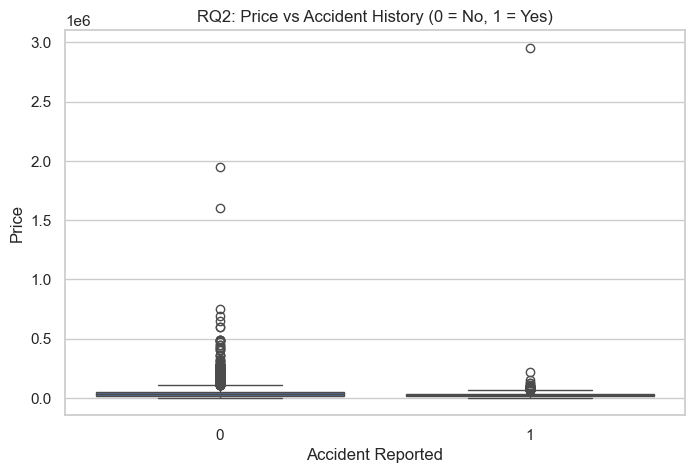

In [4]:
# -------------------------------
# RQ2: Influence of Specific Attributes
# -------------------------------

# Price by Accident History
plt.figure(figsize=(8, 5))
sns.boxplot(x="accident", y="price", data=df)
plt.title("RQ2: Price vs Accident History (0 = No, 1 = Yes)")
plt.xlabel("Accident Reported")
plt.ylabel("Price")
plt.show()


Cars with no reported accidents (0) tend to have slightly higher median prices.

There are more high-priced outliers in the clean category, suggesting that cars with a clean history are generally valued more.

This visual pattern supports the idea that accident history negatively impacts resale value.

Next, I visualize how price varies across different fuel_type categories. This helps me understand which fuel options are more premium and which might be associated with budget vehicles.

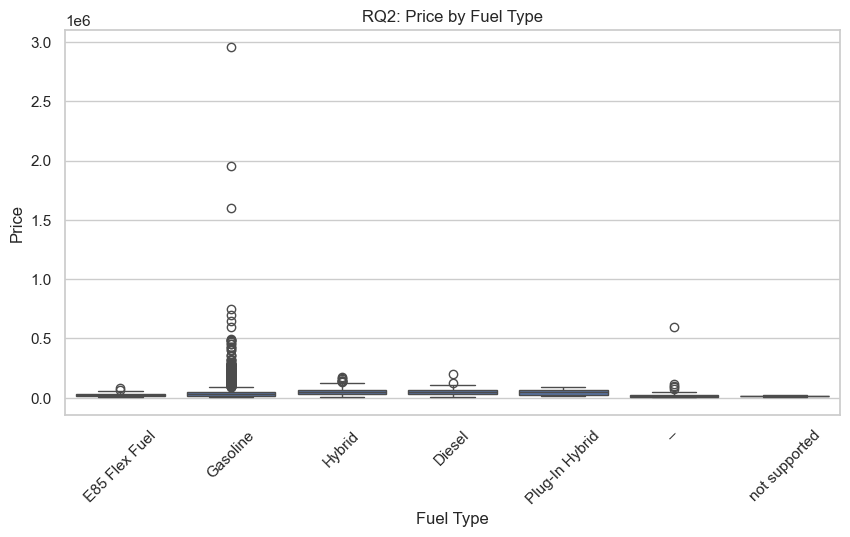

In [5]:
# Price by Fuel Type
plt.figure(figsize=(10, 5))
sns.boxplot(x="fuel_type", y="price", data=df)
plt.title("RQ2: Price by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

Gasoline is the most common and shows the widest range of prices, including many high-value outliers.

Hybrid, Diesel, and Plug-In Hybrid vehicles generally have slightly higher medians than other fuel types.

The category labeled not supported has the lowest overall pricing — possibly reflecting invalid or uncommon entries.

These insights help confirm that both accident history and fuel type are useful predictors when modeling used car price

Next I formally test two hypotheses using statistical methods. This helps me move beyond visual intuition and provide evidence-based conclusions.

In [6]:
# -------------------------------
# H1: Mileage vs Model Year Correlation
# -------------------------------
corr_mileage, _ = pearsonr(df["milage"], df["price"])
corr_year, _ = pearsonr(df["model_year"], df["price"])

print("H1: Correlation with Price")
print(f"  - Mileage:     {corr_mileage:.4f}")
print(f"  - Model Year:  {corr_year:.4f}")
stronger = "Mileage" if abs(corr_mileage) > abs(corr_year) else "Model Year"
print(f"  => Stronger Influence: {stronger}")

H1: Correlation with Price
  - Mileage:     -0.3040
  - Model Year:  0.1958
  => Stronger Influence: Mileage


First, I test whether mileage or model year has a stronger linear relationship with price. I compute the Pearson correlation coefficient for both.

Mileage has a stronger negative correlation with price (-0.3040) than model year has a positive one (+0.1958).

This confirms H1 — that mileage has a greater influence on price than model year, likely because buyers see high mileage as a sign of wear and lower reliability.


Next, I test whether there's a statistically significant difference in prices between cars with clean titles and those without. For this, I perform an independent t-test comparing the two groups.




In [7]:
# -------------------------------
# H2: Clean Title vs Non-Clean Title Price Difference
# -------------------------------
clean_prices = df[df["clean_title"] == 1]["price"]
not_clean_prices = df[df["clean_title"] == 0]["price"]

t_stat, p_value = ttest_ind(clean_prices, not_clean_prices, equal_var=False)

print("\nH2: T-Test for Clean Title vs Not Clean")
print(f"  - T-Statistic: {t_stat:.4f}")
print(f"  - P-Value:     {p_value:.4e}")
if p_value < 0.05:
    print("  => Result: Statistically significant difference in prices.")
else:
    print("  => Result: No statistically significant difference.")


H2: T-Test for Clean Title vs Not Clean
  - T-Statistic: -6.7619
  - P-Value:     2.3009e-11
  => Result: Statistically significant difference in prices.


The t-statistic is -6.76 and the p-value is extremely small (~2e-11).

Since the p-value is well below 0.05, I conclude there is a significant difference in price based on title status.

This supports H2, confirming that cars with clean titles are priced higher, which aligns with buyer expectations for trustworthy ownership history.

Next I build machine learning models to predict used car prices based on important features such as mileage, model year, engine size, horsepower, and title/accident status. I also test Hypothesis H3, which suggests that an advanced model like Random Forest will outperform a baseline Linear Regression model.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# -------------------------------
# RQ3 / H3: Can ML predict prices accurately?
# -------------------------------

# Features and target
features = ["milage", "model_year", "hp", "engine_size", "trans_speed", "accident", "clean_title"]
X = df[features]
y = df["price"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Baseline: Linear Regression
# -------------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# -------------------------------
# Advanced: Random Forest
# -------------------------------
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# -------------------------------
# Evaluation Function
# -------------------------------
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R² Score: {r2:.4f}")
    return {"Model": model_name, "RMSE": rmse, "R2": r2}

# Evaluate both models
results_lr = evaluate_model(y_test, lr_preds, "Linear Regression")
results_rf = evaluate_model(y_test, rf_preds, "Random Forest Regressor")

# -------------------------------
# H3: Is Random Forest better than Linear Regression?
# -------------------------------
better_model = "Random Forest" if results_rf["RMSE"] < results_lr["RMSE"] else "Linear Regression"
print(f"\n H3 Conclusion: {better_model} performs better based on RMSE.")



Linear Regression Performance:
  RMSE: 83160.71
  R² Score: 0.1329

Random Forest Regressor Performance:
  RMSE: 67403.26
  R² Score: 0.4304

 H3 Conclusion: Random Forest performs better based on RMSE.


To evaluate both models, I use:

RMSE (Root Mean Squared Error): lower is better, shows average prediction error.

R² Score: how much variance in price the model explains (1.0 = perfect, 0 = none).

The Random Forest model has a significantly lower RMSE and a much higher R² score than Linear Regression.

This means Random Forest makes more accurate predictions and explains more of the variance in car prices.

Therefore, H3 is supported — a Random Forest Regressor outperforms a simple Linear Regression model for this dataset.

This confirms that using a more flexible, non-linear model helps capture the real-world complexity of car pricing better than a linear approach.